In [1]:
from datasets.dtu import DTUDataset
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os

torch.backends.cudnn.benchmark = True # this increases inference speed a little

# Load pretrained model

In [2]:
from models.mvsnet import CascadeMVSNet
from utils import load_ckpt
from inplace_abn import ABN
model = CascadeMVSNet(n_depths=[8,32,48],
                      interval_ratios=[1.0,2.0,4.0],
                      num_groups=1,
                      norm_act=ABN).cuda()
load_ckpt(model, 'ckpts/_ckpt_epoch_10.ckpt')
model.eval()

CascadeMVSNet(
  (feature): FeatureNet(
    (conv0): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
    )
    (conv1): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (2): ConvBnReLU(
        (conv): Conv2d(16, 16, k

In [3]:
dataset = DTUDataset('/root/autodl-tmp/mvs_training/dtu/', 'test', n_views=5, depth_interval=2.65,
                     img_wh=(512,512))

In [4]:
def decode_batch(batch):
    imgs = batch['imgs']
    proj_mats = batch['proj_mats']
    depths = batch['depths']
    masks = batch['masks']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    return imgs, proj_mats, depths, masks, init_depth_min, depth_interval

imgs, proj_mats, depths, masks, init_depth_min, depth_interval = decode_batch(dataset[80])
unpreprocess = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                           std=[1/0.229, 1/0.224, 1/0.225])

In [14]:
from utils import *
normalize_depth(depths['level_0']).shape

torch.Size([512, 512])

# Visualize an example depth

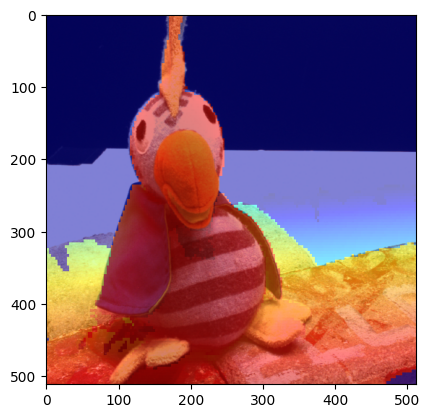

In [6]:


plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(depths['level_0']).permute(1,2,0), alpha=0.5)

In [7]:
imgs.shape,proj_mats.shape

(torch.Size([5, 3, 512, 512]), torch.Size([4, 3, 3, 4]))

# Do inference on this sample

In [8]:
t = time.time()
with torch.no_grad():
    
    results = model(imgs.unsqueeze(0).cuda(), proj_mats.unsqueeze(0).cuda(), init_depth_min, depth_interval)
    torch.cuda.synchronize()
print('inference time', time.time()-t)

inference time 1.8397376537322998


In [9]:
depths['level_0']

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [630.7827, 630.7827, 630.7827,  ...,   0.0000,   0.0000,   0.0000],
        [630.7827, 630.7827, 630.7827,  ...,   0.0000,   0.0000,   0.0000],
        [630.7827, 630.7827, 630.7827,  ...,   0.0000,   0.0000,   0.0000]])

In [10]:
results['depth_0'][0]

tensor([[891.4562, 890.2396, 888.3189,  ..., 900.9167, 899.7061, 898.7991],
        [891.3987, 889.6630, 888.5259,  ..., 903.9771, 903.5502, 903.1082],
        [891.0952, 889.3787, 889.6423,  ..., 907.0394, 907.1780, 906.8914],
        ...,
        [632.8054, 632.4363, 632.1459,  ..., 614.1044, 613.8596, 613.2338],
        [631.4823, 631.6241, 631.3445,  ..., 614.8997, 614.4507, 613.6901],
        [630.1904, 630.1749, 630.3796,  ..., 615.0850, 614.5372, 614.1305]],
       device='cuda:0')

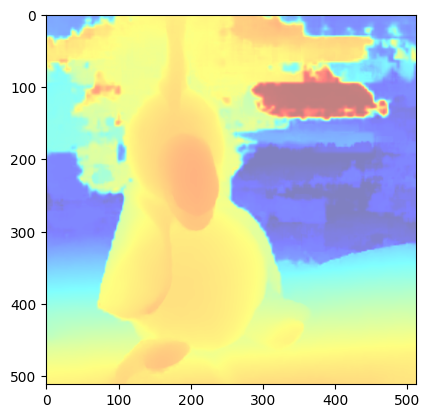

In [11]:
#plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(results['depth_0'][0]).permute(1,2,0), alpha=0.5)

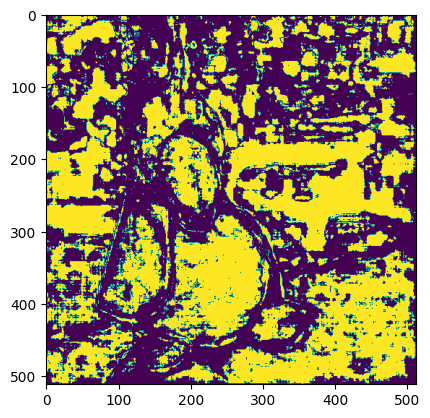

In [12]:
plt.imshow(results['confidence_0'][0].cpu().numpy()>0.999)

# Reference: show pixels whose absolute depth error is less than 2mm

acc_2mm : 0.23119573295116425


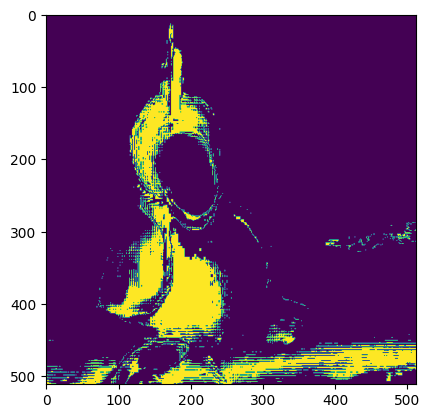

In [13]:
err2 = torch.abs(depths['level_0']-results['depth_0'].cpu())[0]<2
plt.imshow(err2);
print('acc_2mm :', ((err2.float()*masks['level_0']).sum()/masks['level_0'].sum()).item())